In [57]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
import json

# merge some feature of data_patch into data
data = pd.read_csv('./final_data.csv')
data_patch = pd.read_csv('./final_data_patch.csv')

data_size = len(data)
data_patch_size = len(data_patch)
print(data_size)
print(data_patch_size)

'''
commit_id,
author_id,
date,loc,
addition,
deletion,
file_num,
bug_num,

author_activity_in_last_four_weeks, #
total_commit_num, #
buggy_commit_num, #
total_bug_num, #
first_commit_week, #
active_week_num, #

followers,
public_repos,
created_at,

total_commits, #
total_files, #
days_after_creation, #

size,
stargazers_count,
watchers_count,
forks_count,
network_count
'''
used_data_patch_features = [
    'author_activity_in_last_four_weeks', #
    'total_commit_num', #
    'buggy_commit_num', #
    'total_bug_num', #
    #'first_commit_week', #
    'active_week_num', #
    'total_commits', #
    'total_files', #
    'days_after_creation', #
]

# use a dictionary to save the data_patch
patch_dic = {}
for i in range(data_patch_size):
    key = data_patch.loc[i, 'commit_id']
    activity = data_patch.loc[i, 'author_activity_in_last_four_weeks']
    # {'addition': 115, 'deletion': 11, 'commits': 7}
    json_activity = activity.replace(chr(39), chr(34))
    y = json.loads(json_activity)
    value = {
        'author_activity_in_last_four_weeks': y['commits'],
        'total_commit_num': data_patch.loc[i, 'total_commit_num'],
        'buggy_commit_num': data_patch.loc[i, 'buggy_commit_num'],
        'total_bug_num': data_patch.loc[i, 'total_bug_num'],
        #'first_commit_week': data_patch.loc[i, 'first_commit_week'],
        'active_week_num': data_patch.loc[i, 'active_week_num'],
        
        'total_commits': data_patch.loc[i, 'total_commits'],
        'total_files': data_patch.loc[i, 'total_files'],
        'days_after_creation': data_patch.loc[i, 'days_after_creation']
    }
    patch_dic[key] = value

for key, value in patch_dic.items():
    print(key)
    print(value)
    break

# preprocessing the data

column_place_holder = range(data_size)

for i in range(len(used_data_patch_features)):
    data[used_data_patch_features[i]] = column_place_holder

patch_keys = patch_dic.keys()

delete_rows = []

for i in range(data_size):
    commit_id = data.loc[i, 'commit_id']
    if commit_id in patch_keys:
        # add some new data
        for j in range(len(used_data_patch_features)):
            f_str = used_data_patch_features[j]
            data.loc[i, f_str] = patch_dic[commit_id][f_str]
    else:
        # delete this row
        delete_rows.append(i)
        
data.drop(delete_rows,axis = 0,inplace = False)

print(len(data))

1682
1774
e2110b5a6672c889b149b8d276f4374842709ba2
{'author_activity_in_last_four_weeks': 22, 'total_commit_num': 953, 'buggy_commit_num': 14, 'total_bug_num': 19, 'active_week_num': 116, 'total_commits': 31727, 'total_files': 3342, 'days_after_creation': 3026}
1682


In [58]:

threshod1 = 0.008
threshod2 = 0.0025

def foo3(x):
    if x >= threshod1:
        return 2
    if x >= threshod2:
        return 1
    return 0

def foo2(x):
    if x >= threshod1:
        return 1
    return 0

for i in range(data_size):
    data.loc[i, 'bug_num'] = data.loc[i, 'bug_num'] * 1.0 / data.loc[i, 'LOC']
    
data['bug_num'] = data['bug_num'].map(lambda x: foo2(x))



In [59]:
'''
created_at,
updated_at,
size, #
stargazers_count,
watchers_count, #
forks_count, #
network_count, #
subscribers_count, #
followers, #
public_repos, #
created_at,
contributions, #
author_id,
LOC, #
Add, #
Delete, #
Files, #
bug_num  #
commit_id
'''


feature_columns = [
    'size',
    'watchers_count',
    'forks_count',
    'network_count',
    'subscribers_count',
    
    'followers',
    'public_repos',
    'contributions',
    #'LOC',
    #'Add',
    #'Delete',
    'Files',
]
feature_columns = feature_columns + used_data_patch_features
target_column = 'bug_num'

train, test = train_test_split(data, test_size=0.15, random_state=42)

xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)



print("the train size is {}".format(len(train[target_column].values)))
print("the test size is {}".format(len(test[target_column].values)))

params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 2,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 2,
    'silent': 1,
    'eta': 0.1,
    'seed': 111,
    'nthread': 4,
}

# build the model
num_round = 500
bst = xgb.train(params, xgtrain, num_round)



the train size is 1429
the test size is 253
[01:53:37] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [60]:


# prediction and check the accuracy
preds = bst.predict(xgtest)
labels = xgtest.get_label()

match = 0.0
high_risk_match = 0.0
high_risk_count = 0

#project_match = 0
#project_count = 0

high_pred = 1

for i in range(len(preds)):
    # check high risk
    if preds[i] == high_pred:
        high_risk_count += 1
    if preds[i] == labels[i]:
        match += 1
        if preds[i] == high_pred:
            high_risk_match += 1
    
        
# acc
acc = match / len(preds) * 100.0
print("over all accuracy rate is {}".format(acc))

# high risk
print("the model predict {} commit as high risk".format(high_risk_count))
print("{} of them is correct predition".format(high_risk_match))
print()
high_risk_acc = high_risk_match / high_risk_count * 100.0

print("high risk accuracy rate is {}".format(high_risk_acc))



over all accuracy rate is 79.84189723320159
the model predict 87 commit as high risk
61.0 of them is correct predition

high risk accuracy rate is 70.11494252873564


['size', 'watchers_count', 'forks_count', 'network_count', 'subscribers_count', 'followers', 'public_repos', 'contributions', 'Files', 'author_activity_in_last_four_weeks']

['total_commit_num', 'buggy_commit_num', 'total_bug_num', 'active_week_num', 'total_commits', 'total_files', 'days_after_creation']


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

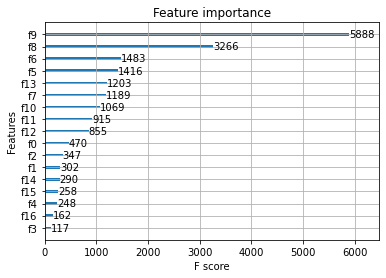

In [61]:
# data analysis
print(feature_columns[0:10])
print()
print(feature_columns[10:17])
plot_importance(bst, importance_type ='weight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

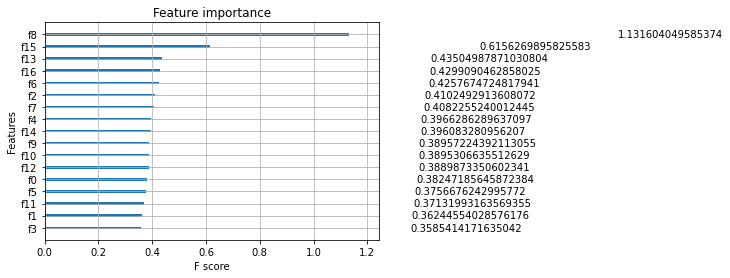

In [62]:
plot_importance(bst, importance_type ='gain')